# ASE2020 submission id #302 -- iCPD

16-03-2020 XXXXXXXXXXX

We proceed in 5 main steps, using an example of estimating a single unknown transition probability in a DTMC from state i to j, say $p_{ij}$:
1. Simulate a window of runtime data.
2. We run the Imprecise Probability with Sets of Priors (IPSP) Bayesian estimator to plot the runtime estimates of $p_{ij}$ when seeing a sudden change.
3. We introduce a **trigger** of our CPD based on the **prior-data conflict** detection feature of IPSP.
4. Do the CPD analysis, if it is indeed triggered.
5. The new IPSP+CPD run time estimates on $p_{ij}$.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(77)

## 1. Now, the first step is to generate some runtime data

In [2]:
w=1000 #the  window size of the data is w
the_cp = 100 # the ground truth change point in that window

the_a = 0.3 # the ground truth transition probability before cp
data_before_cp = np.random.binomial(1, the_a, the_cp)


the_b = 0.7 # the ground truth transition probability after cp
data_after_cp = np.random.binomial(1, the_b, w-the_cp)

data=np.append(data_before_cp,data_after_cp)
print(data,type(data))
print(np.sum(data[0:the_cp]),np.sum(data[the_cp:w]),np.sum(data),len(data))

[1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 0 0 

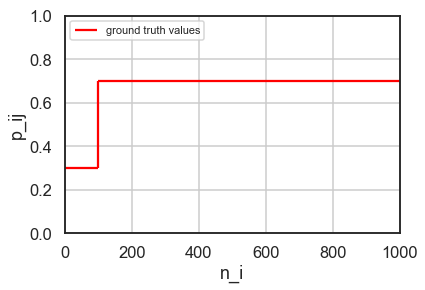

In [3]:
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )
plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)
plt.show()

## 2. Use IPSP to estimate the $p_{ij}$ given the simulated data

In [4]:
# this is the IPSP estimator
def IPSP_est_pij(ni, nij, c_prior_lower, c_prior_upper, mij_prior_lower, mij_prior_upper):
#define function to use sets of priors to update transition probabilityes p_ij (renamed as mij)
#the n_i is the totoal outgoing transitions from state i
#the n_ij is the transtions from i to j.
#the other 4 parameters are defining the set of priors of IPSP
    mij_post_lower=0
    mij_post_upper=0

    if(ni==0):
        return mij_prior_lower, mij_prior_upper
    if(nij/ni) >= mij_prior_lower:
        mij_post_lower=(c_prior_upper*mij_prior_lower+nij)/(c_prior_upper+ni)
        
    if(nij/ni) < mij_prior_lower:
        mij_post_lower=(c_prior_lower*mij_prior_lower+nij)/(c_prior_lower+ni)
        
    if (nij/ni) <= mij_prior_upper:
        mij_post_upper=(c_prior_upper*mij_prior_upper+nij)/(c_prior_upper+ni)
        
    if (nij/ni) > mij_prior_upper:
        mij_post_upper=(c_prior_lower*mij_prior_upper+nij)/(c_prior_lower+ni)

    return mij_post_lower, mij_post_upper

In [5]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=10
n_prior_upper=300
pij_prior_lower=0.2
pij_prior_upper=0.4

current_epoch=1
while current_epoch<len(data):
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[0:current_epoch])
    n_ij=sum(data[0:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

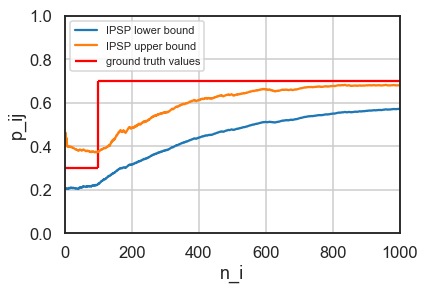

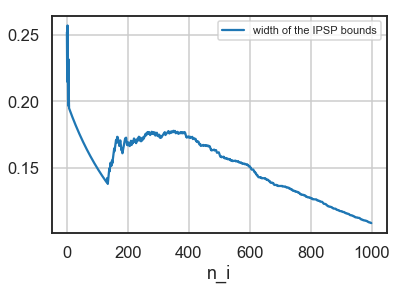

In [6]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(IPSP_est_lower, label='IPSP lower bound',linestyle='-')
plt.plot(IPSP_est_upper, label='IPSP upper bound',linestyle='-')

plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()

plt.plot(np.array(IPSP_est_diff),label='width of the IPSP bounds')
plt.legend(loc='upper right',fontsize=11)
plt.xlabel('n_i')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


## 3. The trigger of CPD

In [7]:

the_tp=0# the trigger point
current_epoch=1 #the trigger point only 
while current_epoch<len(data)-1:
    #if current width is bigger than 1.05 * the minimum width seen so far
    #1.05 the threshold factor that can be changed by experts.
    if current_epoch>50 and IPSP_est_diff[current_epoch]-IPSP_est_diff[current_epoch-1]>0:
        the_tp=current_epoch
        break
    current_epoch=current_epoch+1

In [8]:
#now the window of the data is from 0 to the_tp
if the_tp==0:
    print('no CPD analysis is triigred')
else:
    w=the_tp
    print('the tirgier point is at {}'.format(w))

the tirgier point is at 131


## 4. The CPD analysis

Now let us define our likelihood function

In [9]:
def N(x):
    # return the number of transitions before the x point 
    return np.sum(data[0:x])
     
def M(x):
    # return the number of transitions after the x point 
    return np.sum(data[x:w])

def likelihood(x):
    # simply the binomial likelihood, maybe better to use log- to increase the precision..
    #x=int(x)
    a=np.float64(N(x)/x)
    b=np.float64(M(x)/(w-x))# note, here w!=x..
    return (a**(N(x)))*((1-a)**(x-N(x)))*(b**M(x))*((1-b)**(w-x-M(x)))
    

print(likelihood(the_cp-30),likelihood(w-1))

3.030111702758715e-37 1.006739431013742e-38


Now let us do MCMC samplings...

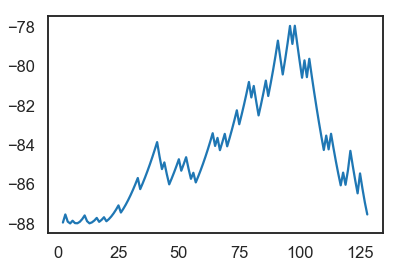

In [10]:

#this code is to visualise the likelihood
def h(b):
    l = []
    for i in b:
        l.append(math.log(likelihood(i)))
    return l
t = np.arange(2, w-2, 1)
plt.plot(t, h(t))
plt.show()


In [11]:
x_current = round(w/2) #starting point of MCMC
x_posterior=[x_current] 
samples=5000 # number of samples
std=8 #the std of the proposal dist. which needs to be fine tuned
test=[1]

for i in range(samples):
    # step 1: from a symetrical normal dist., sample a proposed x 
    
    proposal = np.random.normal(x_current, std, 1) 
    
    while proposal[0]<0 or proposal[0]>w: #the proposal x cannot be out of the data window..
        proposal = np.random.normal(x_current, std, 1)

    proposal=int(proposal[0])

    #step 2: let us decide if we accpet that proposal or not.
    likelihood_current =likelihood(x_current)
    likelihood_proposal =likelihood(proposal)

    # Compute prior probability of current and proposed x        
    prior_current = 1/w #here we assume prior x is unifomly distributed, but you can use others\\
    prior_proposal = 1/w # for sure, then you change here..

    # Nominator of Bayes formula
    p_current = likelihood_current #* prior_current
    p_proposal = likelihood_proposal #* prior_proposal

    p_accept = p_proposal / p_current
    

    accept = np.random.rand() < p_accept
    test.append(accept) # record the number of proposals being accpeted for fine tune.

    # if accpet then change the x_current and put the accpected sample in to posterior

    if accept:
    # Update position
        x_current = proposal
        x_posterior.append(x_current)



Text(36, 0.05, 'Variance=82.406129')

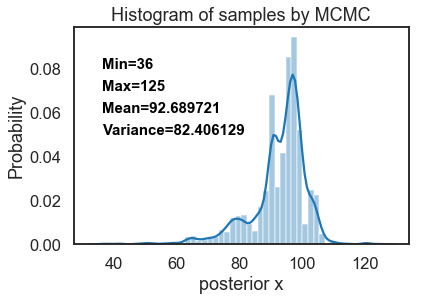

In [12]:
ax = plt.subplot()
sns.distplot(x_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior x', ylabel='Probability');

ax.text(min(x_posterior),0.08,'Min=%d'%min(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.07,'Max=%d'%max(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.06,'Mean=%f'%sp.mean(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.05,'Variance=%f'%sp.var(x_posterior),size=15, color='black', weight='semibold')


In [13]:
print(sum(test)/samples)# tune the std in the MCMC, good range is 0.2-0.5
print(sum(test))

0.4164
2082


Text(0.45263157894736844, 14, 'Variance=0.003067')

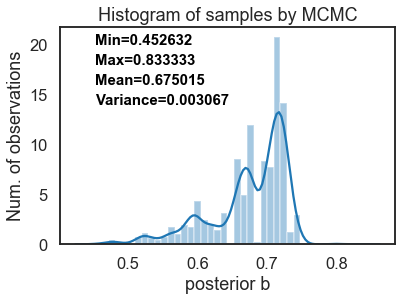

In [14]:
# correspondingly the posterior for b is
def calulate_b_post(x_post):
    b_post = []
    for i in x_post:
        b_post.append((M(i))/(w-i))
    return b_post

b_posterior=calulate_b_post(x_posterior)
ax = plt.subplot()

sns.distplot(b_posterior, ax=ax, kde=True, hist=True, bins=40)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior b', ylabel='Num. of observations');

ax.text(min(b_posterior),20,'Min=%f'%min(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),18,'Max=%f'%max(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),16,'Mean=%f'%sp.mean(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),14,'Variance=%f'%sp.var(b_posterior),size=15, color='black', weight='semibold')

Now do some statistics on the two posterior distributions

In [15]:
print(sp.stats.describe(x_posterior))
print(sp.stats.describe(b_posterior))

DescribeResult(nobs=2082, minmax=(36, 125), mean=92.68972142170989, variance=82.44572803384169, skewness=-1.5824080119753228, kurtosis=4.613284612637839)
DescribeResult(nobs=2082, minmax=(0.45263157894736844, 0.8333333333333334), mean=0.6750147675277939, variance=0.003067973764391115, skewness=-1.2431187052847608, kurtosis=1.1688337328829874)


## 5. The new IPSP+CPD run time estimates on $p_{ij}$.

First, based on the CPD analysis, we use the mean of the posterior distribution of x as the estimated change point.

In [16]:
est_x=int(np.mean(x_posterior))
print(est_x)

92


Now, before the change point, the IPSP estimates are:

In [17]:
IPSP_est_upper_before_cp=[]
IPSP_est_lower_before_cp=[]
IPSP_est_diff_before_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=10
n_prior_upper=300
pij_prior_lower=0.2
pij_prior_upper=0.4

current_epoch=1
while current_epoch<=est_x:#before the cp
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[0:current_epoch])
    n_ij=sum(data[0:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_before_cp.append(temp_lower)
    IPSP_est_upper_before_cp.append(temp_upper)
    IPSP_est_diff_before_cp.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

While, after the estimated change point:
(Note, the way we construct the new set of priors for IPSP after the change point is:
1. the min and max of b posterior distribution are the prior lower and upper for mean $p_{ij}$.  Actually, I feel, to be conservative, we may want to make the initial bounds a bit wider..
2. Since the prior mean bounds are obtained from the number of trials from the change point the trigger point, so the lower and upper prior confidence parameter should be the_tp-max(x_posterior) and the_tp-min(x_posterior) respectively.

In [18]:
IPSP_est_upper_after_cp=[]
IPSP_est_lower_after_cp=[]
IPSP_est_diff_after_cp=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=the_tp-max(x_posterior)
n_prior_upper=the_tp-min(x_posterior)
pij_prior_lower=1*np.min(b_posterior)
pij_prior_upper=1*np.max(b_posterior)# we could make the intial bounds wider

print(n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)

current_epoch=est_x+1
while current_epoch<=len(data):#before the cp
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[est_x:current_epoch])# starting from est_x -- the cp.
    n_ij=sum(data[est_x:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower_after_cp.append(temp_lower)
    IPSP_est_upper_after_cp.append(temp_upper)
    IPSP_est_diff_after_cp.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

6 95 0.45263157894736844 0.8333333333333334


In [19]:
new_IPSP_est_upper=np.append(IPSP_est_upper_before_cp,IPSP_est_upper_after_cp)
new_IPSP_est_lower=np.append(IPSP_est_lower_before_cp,IPSP_est_lower_after_cp)
new_IPSP_est_diff=np.append(IPSP_est_diff_before_cp,IPSP_est_diff_after_cp)

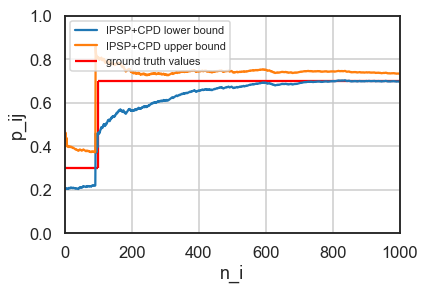

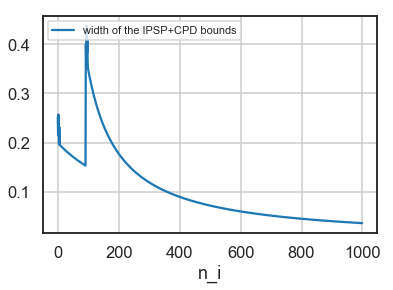

In [20]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=len(data),
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(new_IPSP_est_lower, label='IPSP+CPD lower bound')
plt.plot(new_IPSP_est_upper,label='IPSP+CPD upper bound')

plt.axis([0, len(data), 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()

plt.plot(np.array(new_IPSP_est_diff),label='width of the IPSP+CPD bounds')
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


Now, since we are both scientist and artist at the same time, we would like to present this kind of figures:

In [21]:
print(w)

131


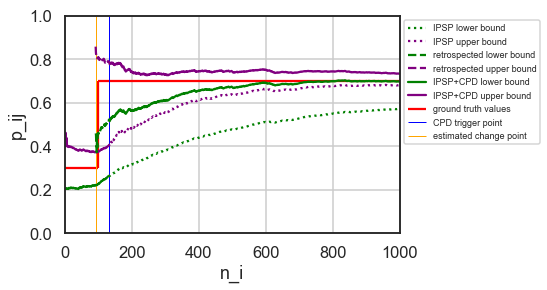

In [22]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=len(data),
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.vlines(x=w, ymin=0,ymax=1,linestyle='-',color='b',label='CPD trigger point',linewidth=1)
plt.vlines(x=est_x, ymin=0,ymax=1,linestyle='-',color='orange',label='estimated change point',linewidth=1)

x_index = range(len(IPSP_est_lower))#only for aiding the plots...

plt.plot(IPSP_est_lower[:w-1],linestyle='-',color='green')
plt.plot(IPSP_est_upper[:w-1] ,linestyle='-',color='purple')
plt.plot(x_index[w:],IPSP_est_lower[w:],linestyle='dotted',color='green',label='IPSP lower bound')
plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')




plt.plot(x_index[est_x:w],new_IPSP_est_lower[est_x:w],label='retrospected lower bound', linestyle='dashed',color='green')
plt.plot(x_index[est_x:w],new_IPSP_est_upper[est_x:w],label='retrospected upper bound', linestyle='dashed',color='purple')
plt.plot(x_index[w:],new_IPSP_est_lower[w:-1],label='IPSP+CPD lower bound', linestyle='-',color='green')
plt.plot(x_index[w:],new_IPSP_est_upper[w:-1],label='IPSP+CPD upper bound', linestyle='-',color='purple')

plt.axis([0, len(data), 0, 1])# set the ranges of axis
plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()